In [46]:
%matplotlib inline
import sys
import os
sys.path.append('/home/kihyun/data/projects/kihyun/Editing-benchmark/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [47]:
dataDir='/home/kihyun/data/dataset/COCO2017'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
capFile='{}/annotations/captions_{}.json'.format(dataDir,dataType)
json_dir = '/home/kihyun/data/projects/kihyun/Editing-benchmark/edit_task_v2.json'
#catnms = ['dog'] # 해당 object가 모두 있는 이미지만 선택 및 프롬프트 저장
#Annotation = False # Annotation mask를 이미지에 표시할지 여부
save_dir = './category_test' # 프롬프트 저장 위치
#save_img = True
img_num = 30

In [48]:
# cat_dir = '_'.join(catnms) # 프롬프트 저장 위치
# save_path = os.path.join(save_dir, cat_dir)
# if not os.path.exists(save_path):
#         os.makedirs(save_path)

In [49]:
# initialize COCO api for instance annotations
# annotation file을 읽어서 COCO object를 생성
coco_ann=COCO(annFile)  # COCO object를 생성, 이미지, 마스크 정보를 읽어옴
coco_cap=COCO(capFile) # caption 정보를 읽어옴 : text prompt 생성에 사용

loading annotations into memory...
Done (t=12.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.80s)
creating index...
index created!


In [50]:
def show_mask(imgId, catId, coco_ann): # 이미지에 mask를 표시
    annId = coco_ann.getAnnIds(imgIds=imgId, catIds=catId)
    anns = coco_ann.loadAnns(annId)
    coco_ann.showAnns(anns)

def show_img_caption(imgId, coco_cap, catnms): # 이미지와 caption을 표시
    annIds_cap = coco_cap.getAnnIds(imgIds=imgId)
    anns_cap = coco_cap.loadAnns(annIds_cap)
    catId = coco_ann.getCatIds(catNms=catnms)
    
    img = coco_cap.loadImgs(imgId)[0]
    I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    plt.axis('off')
    plt.imshow(I)
    show_mask(imgId, catId, coco_ann)
    plt.show()
    
    for i in range(len(anns_cap)):
        ann = anns_cap[i]    
        print(ann['caption'])

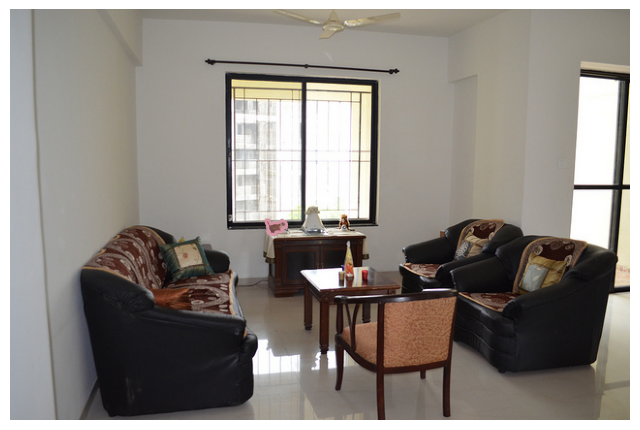

A living room filled with a couch and two chairs.
A very sparse living room with leather furniture
Furniture in a white walled, tiled living room
a living room with some couches and a dresser 
A black couch is facing a table and two chairs.


In [51]:
show_img_caption(98304, coco_cap, ['dog']) # 이 경우 dog가 있지만 너무 작아서 제외해야한다.
# 이 외에도 잘린 경우와 같이 main object가 아닌 경우 제외해야한다.

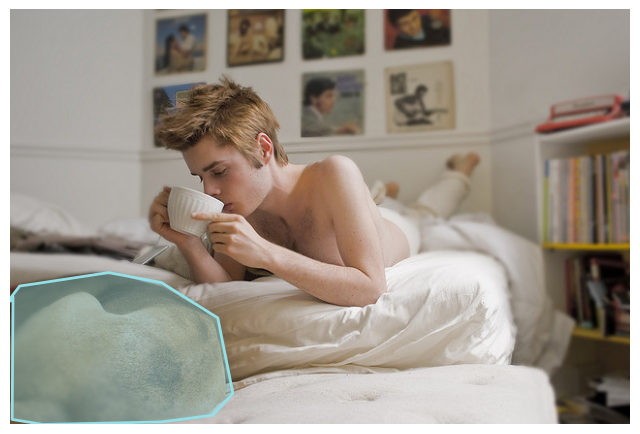

A man lies in bed next to a canine under a blanket.
Guy lays on bed sipping from a cup while dog curls up in front of him.
A shirtless man laying in bed with a cup of coffee.
A person drinks from a mug on a bed.
A shirtless boy drinking a beverage while lying in bed


In [53]:
show_img_caption(311301, coco_cap, ['dog'])
# 개처럼 보이지 않는 경우도 존재 -> 제외
# 모든 prompt에서 dog가 나타나는 경우만 선택 필요

In [54]:
# 모든 prompt에서 object_str이 나타나는 경우만 선택
def check_object_in_cap(anns_cap, object_str):
    ans = 1
    for ann in anns_cap:
        if object_str in ann['caption']:
            continue
        else:
            ans=0
            break 
    return ans
def get_imgs_with_obj(catnms, coco_cap, coco_ann): # catnms only one object
    imgIds_with_obj = []
    
    catIds = coco_ann.getCatIds(catNms=catnms)
    imgIds = coco_ann.getImgIds(catIds=catIds)
    
    for imgId in imgIds:
        
        annIds_cap = coco_cap.getAnnIds(imgIds=imgId)
        anns_cap = coco_cap.loadAnns(annIds_cap)
        
        if check_object_in_cap(anns_cap, catnms[0]):
            if len(anns_cap) > 0:
                imgIds_with_obj.append(imgId)
    return imgIds_with_obj # list of imgIds that has object_str in all captions

In [55]:
catnms = ['dog']
dog_imgIds = get_imgs_with_obj(catnms, coco_cap, coco_ann) # 사용 예시
print(len(dog_imgIds))

2243


In [65]:
def img_idx_list(coco, catnms): # catnms = ['person', 'dog'] 에 해당하는 이미지들의 id를 반환
    catIds = coco.getCatIds(catNms=catnms)
    imgIds = coco.getImgIds(catIds=catIds)
    print("Number of images containing all of the categories: ", len(imgIds))
    return len(imgIds), imgIds

def img_show(coco, imgId, mask=False, catnms=None, save_dir=save_dir):
    img = coco.loadImgs(imgId)[0]
    I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    #I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    if mask:
        catIds = coco.getCatIds(catNms=catnms)
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        coco.showAnns(anns)
    
    # save image
    save_name = f'{imgId}.jpg'
    save_dir = os.path.join(save_dir, catnms[0])
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    img_path = os.path.join(save_dir, save_name)
    plt.savefig(img_path)
    plt.clf()
    
def multi_img_save(coco, imgId_ls, mask=False, catnms=None, save_num = img_num, save_dir=save_dir):
    i = 0
    print(f'Number of images downloaded: {save_num}')
    for imgId in imgId_ls:
        if i == save_num:
            break
        img_show(coco, imgId, mask, catnms, save_dir=save_dir)
        i += 1
        
def save_edit_prompts(catnms, json_dir, save_dir=save_dir):
    # read json file
    with open(json_dir, 'r') as f:
        json_data = json.load(f)
    # save edit prompts in prompt_save_dir
   
    file_name = f'edit_prompts_{catnms}.txt'
    txt_path = os.path.join(save_dir, file_name)
    ff = open(txt_path, 'w')
    for cat in catnms:
        for edit_task in json_data[cat].keys():
            for subtask in json_data[cat][edit_task]['to']:
                ff.write(f'{cat}, {edit_task}, {subtask}\n')
                ff.write('---------------------\n')
    ff.close()
    
def show_cat_imgs_n_prompt(coco, catnms, json_dir):
    n, imgId_ls = img_idx_list(coco, catnms)
    multi_img_show(coco, imgId_ls, mask=Annotation, catnms=catnms)
    save_edit_prompts(catnms, json_dir)

In [ ]:
multi_img_save(coco_ann, dog_imgIds, catnms=['dog'], save_num=2243, save_img=save_img, save_path=save_dir)
# dog가 명확하게 들어있는 이미지들을 저장

### 모든 object class에 대해 개수 뽑기
### 다운 받은 이미지들 해당 object가 명확히 보이는지 확인하자
### cropping이 필요할지 확인 -> center crop 하면 positional editing 가능할듯

In [59]:
cats = coco_ann.loadCats(coco_ann.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))
print(len(nms))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

80


In [63]:
for obj in nms:
    catnms = [obj]
    imgIds = get_imgs_with_obj(catnms, coco_cap, coco_ann)
    print(f'Number of {obj} images: {len(imgIds)}')
    
    #save_edit_prompts(catnms, json_dir, save_path=save_path)

Number of person images: 78
Number of bicycle images: 23
Number of car images: 384
Number of motorcycle images: 665
Number of airplane images: 31
Number of bus images: 1941
Number of train images: 2108
Number of truck images: 763
Number of boat images: 853
Number of traffic light images: 8
Number of fire hydrant images: 540
Number of stop sign images: 322
Number of parking meter images: 125
Number of bench images: 1179
Number of bird images: 676
Number of cat images: 2516
Number of dog images: 2243
Number of horse images: 1770
Number of sheep images: 390
Number of cow images: 463
Number of elephant images: 1604
Number of bear images: 682
Number of zebra images: 1101
Number of giraffe images: 1646
Number of backpack images: 3
Number of umbrella images: 1111
Number of handbag images: 0
Number of tie images: 345
Number of suitcase images: 35
Number of frisbee images: 126
Number of skis images: 45
Number of snowboard images: 190
Number of sports ball images: 0
Number of kite images: 1019
N

In [66]:
for obj in nms:
    catnms = [obj]
    imgIds = get_imgs_with_obj(catnms, coco_cap, coco_ann)
    
    multi_img_save(coco_ann, imgIds, catnms=catnms, save_num=len(imgIds), save_dir=save_dir, mask=True)

Number of person images: 78
Number of images downloaded: 78
Number of bicycle images: 23
Number of images downloaded: 23
Number of car images: 384
Number of images downloaded: 384
Number of motorcycle images: 665
Number of images downloaded: 665
Number of airplane images: 31
Number of images downloaded: 31
Number of bus images: 1941
Number of images downloaded: 1941
Number of train images: 2108
Number of images downloaded: 2108
Number of truck images: 763
Number of images downloaded: 763
Number of boat images: 853
Number of images downloaded: 853
Number of traffic light images: 8
Number of images downloaded: 8
Number of fire hydrant images: 540
Number of images downloaded: 540
Number of stop sign images: 322
Number of images downloaded: 322
Number of parking meter images: 125
Number of images downloaded: 125
Number of bench images: 1179
Number of images downloaded: 1179
Number of bird images: 676
Number of images downloaded: 676
Number of cat images: 2516
Number of images downloaded: 2

<Figure size 800x1000 with 0 Axes>